<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/autoencoder_outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders for Outlier Detection

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
# mpl.rcParams["figure.dpi"] = 300

mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [3]:
import numpy as np
np.random.seed(42)

In [4]:
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.8.2'

In [5]:
tf.random.set_seed(42)

In [6]:
!nvidia-smi

Wed Oct  5 07:45:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

     |████████████████████████████████| 71 kB 8.3 MB/s 
     |████████████████████████████████| 1.6 MB 48.1 MB/s 


In [8]:
from lrcurve import KerasLearningCurve

# Step 1: Load and prepare data

In [9]:
# screenshots from the application that is supposed to be mainly correct
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/app-testing/golden-master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7589k  100 7589k    0     0  10.2M      0 --:--:-- --:--:-- --:--:-- 10.2M


In [10]:
!unzip -jqo golden-master.zip -d train

In [11]:
# !ls train

In [12]:
# screenshots from the new version containing regressions
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/app-testing/regression.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  830k  100  830k    0     0  2263k      0 --:--:-- --:--:-- --:--:-- 2263k


In [13]:
!unzip -jqo regression.zip -d test

In [14]:
# !ls -l test

In [15]:
# for a symmetric form of the autoencoder, a power of two for the resolution is easiest
res = (256, 256)
x_res, y_res = res

In [16]:
color = False
# color = True
# color_channels = 3
color_channels = 1

In [17]:
import os
import numpy as np
from skimage import data, io, filters
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray, rgba2rgb

def read_images_from_dir(data_dir, dims=(356, 384), res=(256, 256), type = ".png"):
  x_res, y_res = res
  x_dim, y_dim = dims
  images = []
  file_names = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(type)]
  for f in file_names:
    image = io.imread(f)
    # some images from regressed application often have an additional line break
    # we take the easy route and simply clip to have the same size for all images
    image = image[:x_dim, :y_dim]
    if color:
      # getting rid of alpha channel (going from 4 to 3 color channels)
      # image = rgba2rgb(image) # seems to mess up values and shifts them slightly beyond 1
      image = image[:,:,:3]
    else:
      image = rgb2gray(image) # seems to mess up values and shifts them slightly beyond 1
    image = resize(image, (x_res, y_res))
    images.append(image)

  images = np.array(images)

  return images

In [18]:
train = read_images_from_dir("train")
train.shape, train.dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.


((603, 256, 256), dtype('float64'))

In [19]:
# should be [0 .. 1]
np.min(train), np.max(train)

(0.0015856314570710417, 1.0000000000000002)

In [20]:
train = np.clip(train, 0, 1)
np.min(train), np.max(train)

(0.0015856314570710417, 1.0)

In [21]:
input_shape = train.shape[1:]
input_shape

(256, 256)

In [22]:
test = read_images_from_dir("test")
test.shape, test.dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.


((51, 256, 256), dtype('float64'))

In [23]:
np.min(test), np.max(test)

(0.0019093871408975716, 1.0000000000000002)

In [24]:
test = np.clip(test, 0, 1)
np.min(test), np.max(test)

(0.0019093871408975716, 1.0)

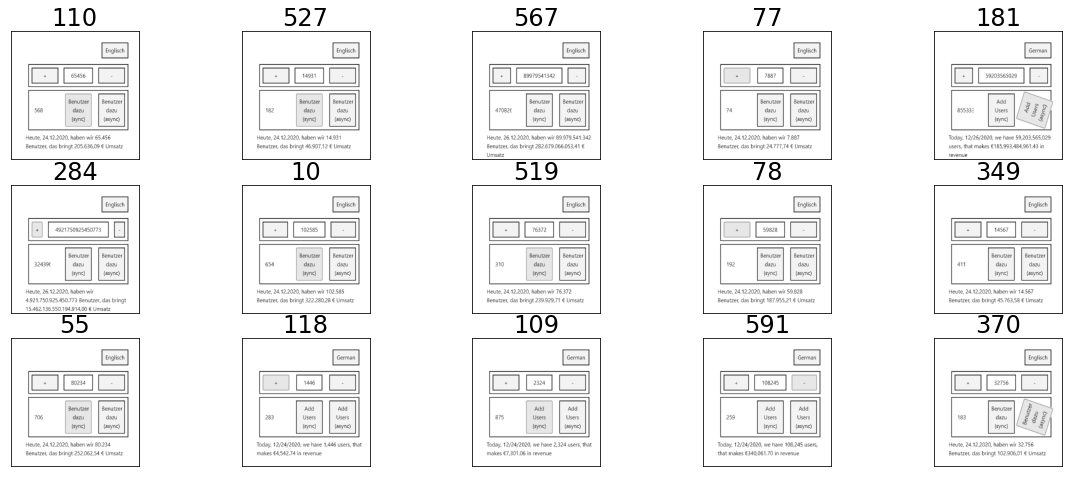

In [25]:
def plot_samples(x, n_samples=15):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      if color:
        ax.imshow(x[index])
      else:
        ax.imshow(x[index], cmap="gray")
      ax.set_title("{}".format(index))
        
plot_samples(train)

# Step 2: Train a Deep CNN Autoencoder

* Encoder uses convolutional layers
* Decoder does deconvoluation
* Bottleneck minimally uses 8 neurons, but these can be easily configured. Less than 8 will probably not train
* l2 to compress latent space a bit
* could use l1 to increase sparsity of embedding when having dim > 2, to have an additional restriction (often gives better results)
*  rounded accuracy counts how many pixels match approximately

In [26]:
from tensorflow import keras

# rounded to b/w, how many pixels fit approximately?
# taken from: https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb#scrollTo=vTfcqDgW-Kff
@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [27]:
def rounded_accuracy_for_single_image(true, predicted):
  return tf.reduce_mean(rounded_accuracy(true, predicted.astype('float64'))).numpy()    

In [28]:
# going much lower will not work
# encoding_dim = 8
encoding_dim = 32
# seems to work a bit nicer, but reducing for viz gives worse results
# encoding_dim = 16

In [29]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential

from tensorflow import keras

kernel_size = 4
stride = 2

conv_encoder = Sequential([
    Input(shape=input_shape),
    Reshape((x_res, y_res, color_channels)),
    Conv2D(64, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(16, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # MaxPooling2D(pool_size=2),
    # Conv2D(8, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # MaxPooling2D(pool_size=2),
    # Conv2D(4, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # MaxPooling2D(pool_size=2),
    # Conv2D(1, name='collection_image', kernel_size=kernel_size, strides=1, padding="same"),
    Flatten(),
    # this creates our latent representation
    Dense(encoding_dim, 
          name='latent_representation',
          # activation="relu", 
          activation="linear", 
          # activity_regularizer=keras.regularizers.l2(1e-4),
          # activity_regularizer=keras.regularizers.l1(5e-4)),
          # activity_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=1e-4)
         ),

])
conv_decoder = Sequential([
    # this accepts the latent representation
    Input(shape=(encoding_dim)),
    Dense(1024),
    # Reshape((4, 4, 1)),
    # Reshape((1, 1, encoding_dim)),
    Reshape((32, 32, 1)),
    # Conv2DTranspose(8, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # UpSampling2D(size=2),
    # Conv2DTranspose(16, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # UpSampling2D(size=2),
    Conv2DTranspose(32, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # UpSampling2D(size=2),
    Conv2DTranspose(64, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(color_channels, kernel_size=kernel_size, strides=1, padding="same", activation="sigmoid"),
    Reshape(input_shape)
])
conv_ae = Sequential([conv_encoder, conv_decoder])

# https://stackoverflow.com/questions/57357146/use-ssim-loss-function-with-keras

# Loss functtion
@tf.function
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=2.0, filter_size=25, filter_sigma=1.5))
  # return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

conv_ae.compile(
    optimizer='adam',
    # optimizer='sgd', # will not train
    loss="binary_crossentropy", 
    # loss=ssim_loss,
    # loss="mae", # will not train either 
    # loss="mse", # will not train either
    metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          8

In [30]:
from tensorflow.keras.utils import plot_model
# plot_model(conv_encoder, to_file="encoder.png", show_shapes=True, show_layer_names=False, dpi=300)
# plot_model(conv_encoder, show_shapes=True, show_layer_names=False)

In [31]:
# plot_model(conv_decoder, to_file="decoder.png", show_shapes=True, show_layer_names=False, dpi=300)
# plot_model(conv_decoder, show_shapes=True, show_layer_names=False)

In [32]:
%%time

# bring this down if training does not work any more
# can be higher when diemension of hidden representation is higher
BATCH_SIZE = 4 # for 16
# BATCH_SIZE = 2 # for 8
# typically is more than enough
# EPOCHS = 100
EPOCHS = 50

history = conv_ae.fit(train, train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(test, test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 1min 24s, sys: 5.32 s, total: 1min 29s
Wall time: 1min 54s


In [33]:
train_loss, train_accuracy = conv_ae.evaluate(train, train, batch_size=BATCH_SIZE, verbose=0)
train_accuracy

0.9852868914604187

In [34]:
test_loss, test_accuracy = conv_ae.evaluate(test, test, batch_size=BATCH_SIZE, verbose=0)
test_accuracy

0.9753995537757874

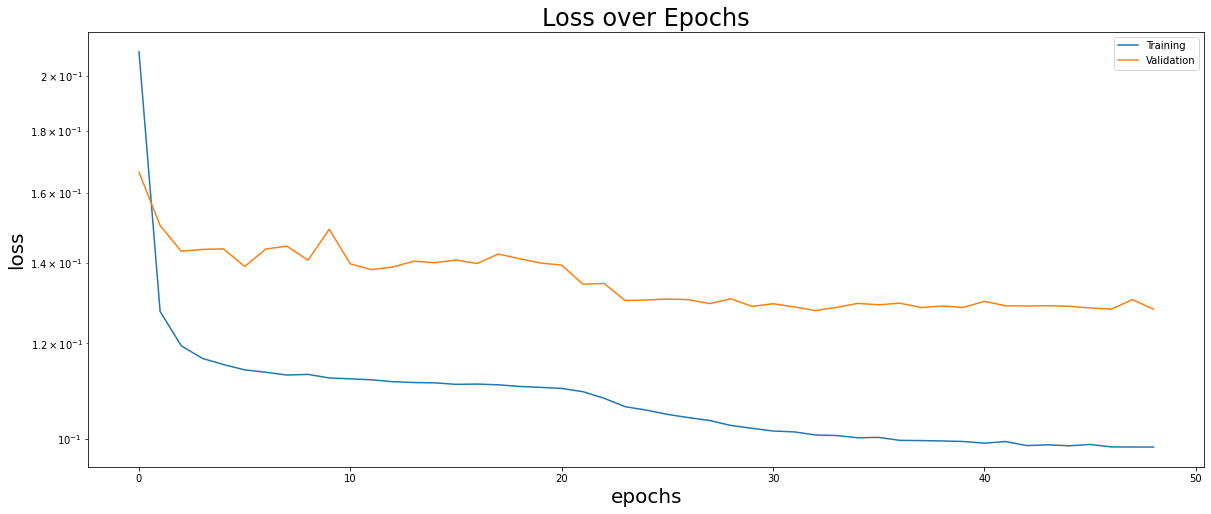

In [35]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Validation']);

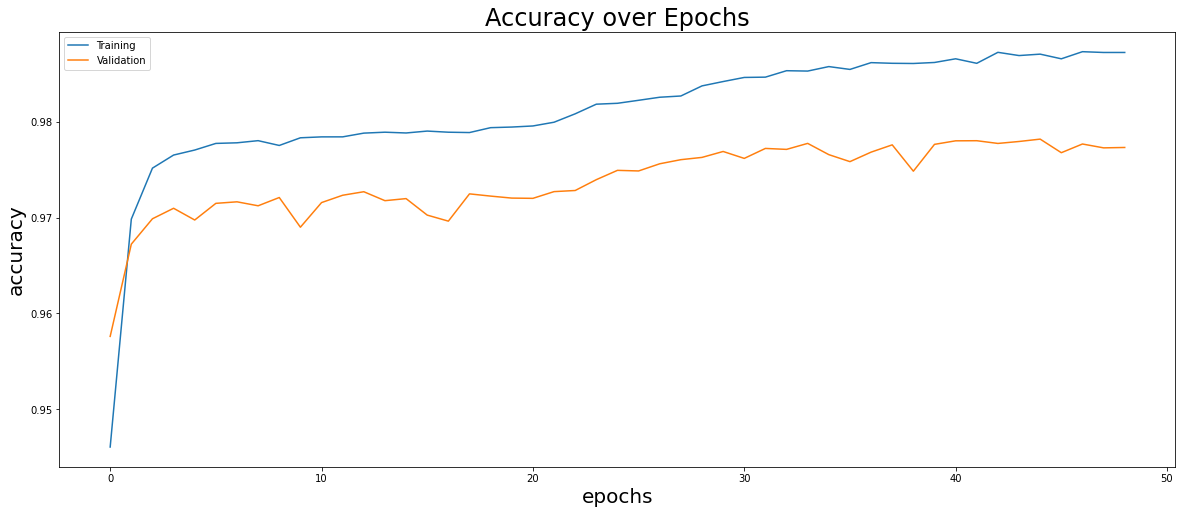

In [36]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over Epochs')

plt.plot(history.history['rounded_accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_rounded_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Validation']);

# Step 3: Validate Results

In [37]:
train_pred = conv_ae.predict(train)
# plot_samples(train_pred)

### True

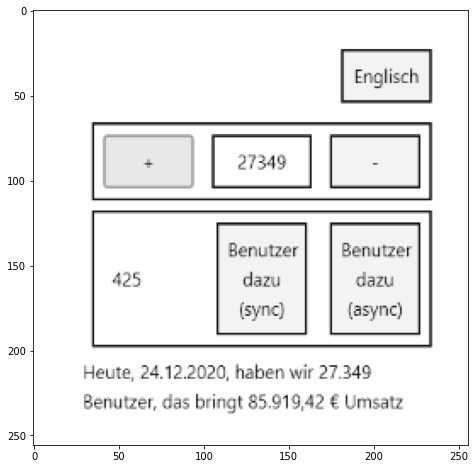

In [38]:
index = 50
if color:
  plt.imshow(train[index]);
else:
  plt.imshow(train[index], cmap='gray');

# io.imsave('train_true.png', train[index])

### Prediction

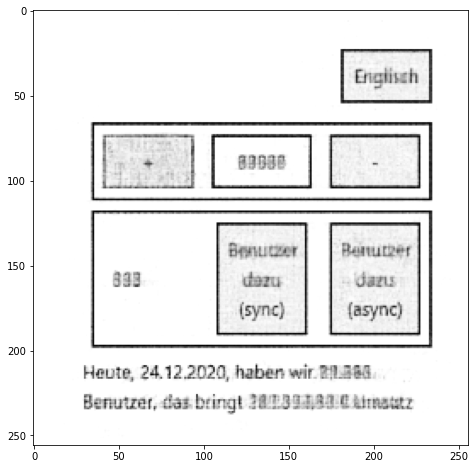

In [39]:
if color:
  plt.imshow(train_pred[index]);
else:
  plt.imshow(train_pred[index], cmap='gray');

# io.imsave('train_pred.png', train_pred[index])

In [40]:
rounded_accuracy_for_single_image(train[50], train_pred[50])

0.98599243

In [41]:
test_pred = conv_ae.predict(test)
# plot_samples(test_pred)

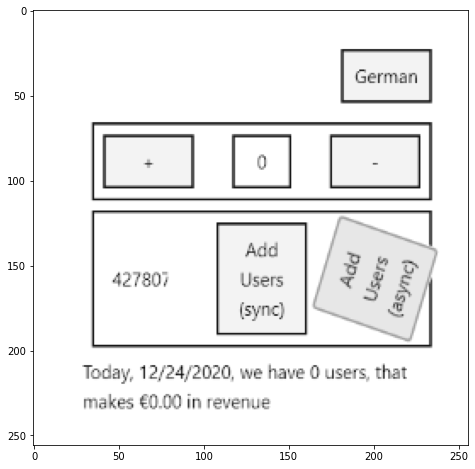

In [42]:
index = 21
# index = 24
if color:
  plt.imshow(test[index]);
else:
  plt.imshow(test[index], cmap='gray');

# io.imsave('test_true.png', test[index])

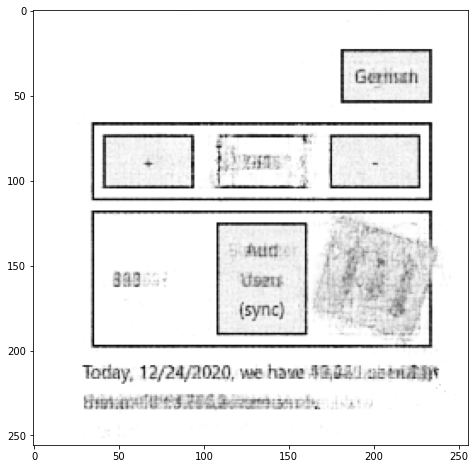

In [43]:
if color:
  plt.imshow(test_pred[index]);
else:
  plt.imshow(test_pred[index], cmap='gray');

# io.imsave('test_pred.png', test_pred[index])

In [44]:
rounded_accuracy_for_single_image(test[0], test_pred[0])

0.97047424

## Comparing samples from Training Set

In [45]:
def compare_samples(x, x_pred, n_samples=5, display_accuracy=True):
  n_samples = min(n_samples, len(x))
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.set_title("{}".format(index))
      if color:
        ax.imshow(x[index])
      else:
        ax.imshow(x[index], cmap="gray")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      if display_accuracy:
        acc = rounded_accuracy_for_single_image(x[index], x_pred[index])
        ax.set_title("{:.4f}".format(acc))
      if color:
        ax.imshow(x_pred[index])
      else:
        ax.imshow(x_pred[index], cmap="gray")

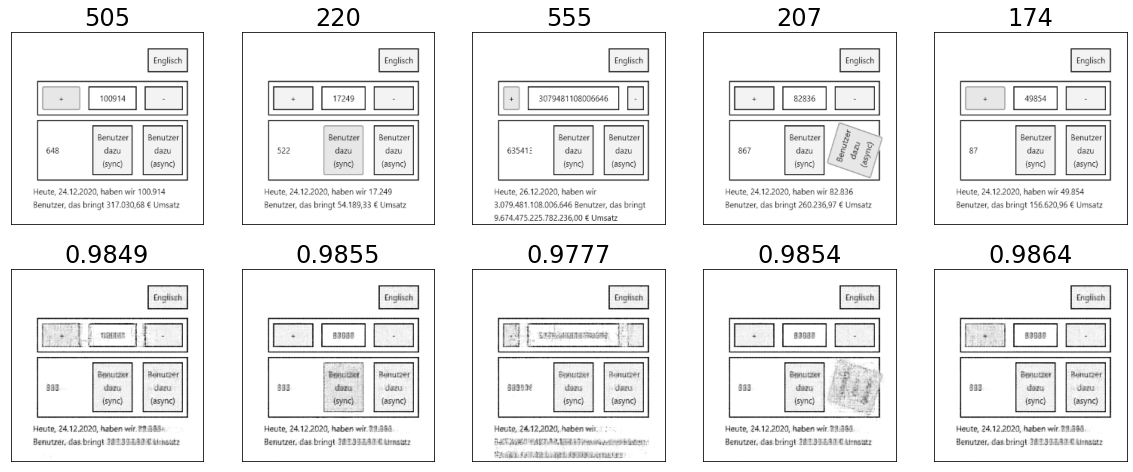

In [46]:
compare_samples(train, train_pred)

In [47]:
scores = []
for true_image, predicted_image in zip(train, train_pred):
  score = rounded_accuracy_for_single_image(true_image, predicted_image)
  scores.append(score)
train_scores = np.array(scores)  
train_scores.shape

(603,)

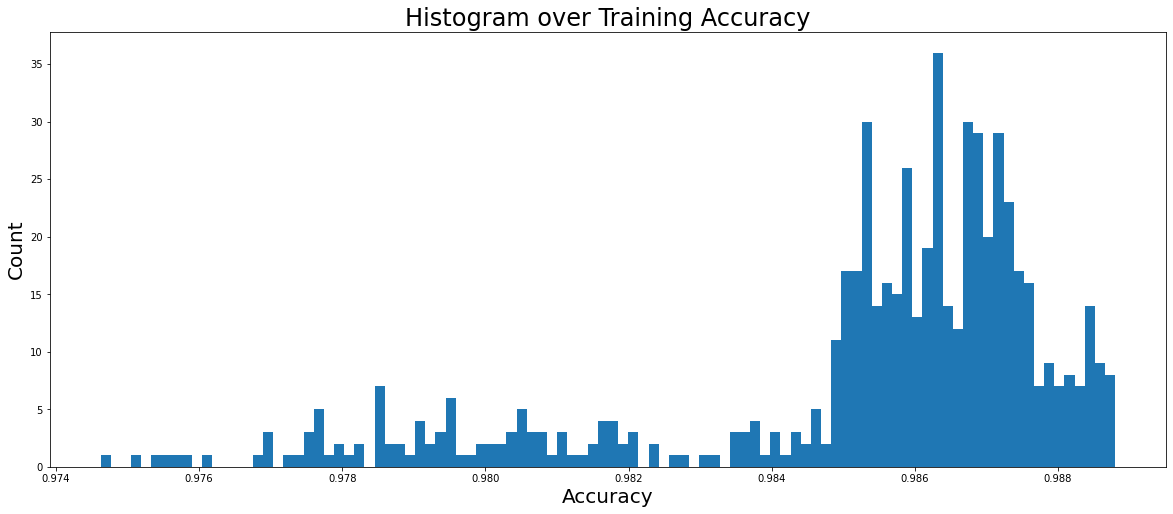

In [48]:
plt.title('Histogram over Training Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

plt.hist(train_scores, bins=100);

## Comparing samples from Regression Test Set

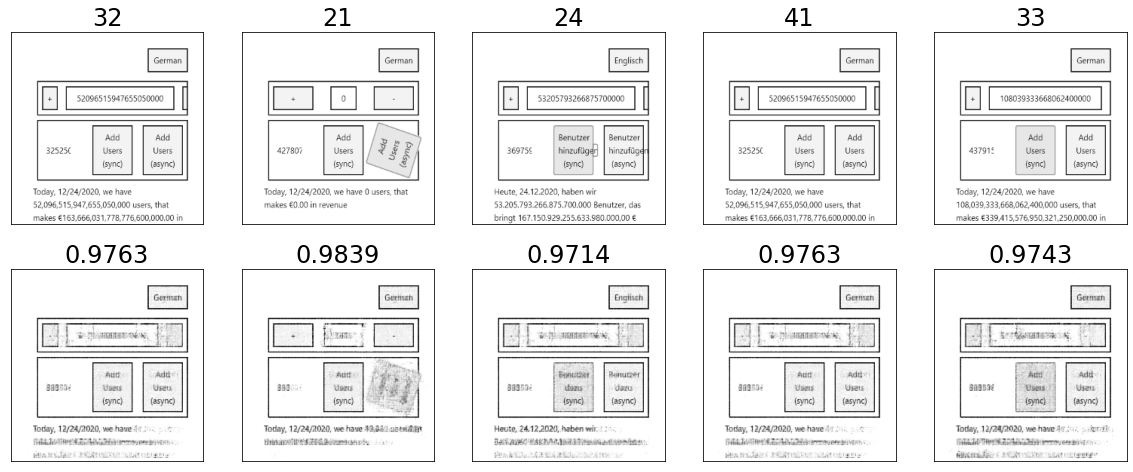

In [49]:
compare_samples(test, test_pred)

In [50]:
scores = []
for true_image, predicted_image in zip(test, test_pred):
  score = rounded_accuracy_for_single_image(true_image, predicted_image)
  scores.append(score)
test_scores = np.array(scores)  
test_scores.shape

(51,)

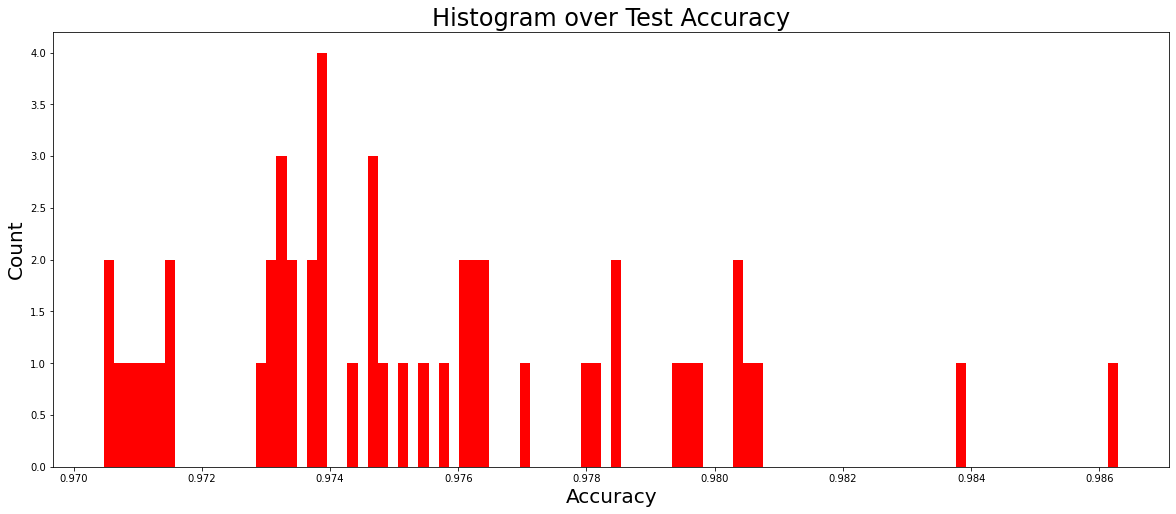

In [51]:
plt.title('Histogram over Test Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

plt.hist(test_scores, bins=100, color='red');

# Step 4: Identify suspicious screenshots from test set

Suspicious Screenshots: 49 von 51
Unsuspicious Screenshots: 509 von 603


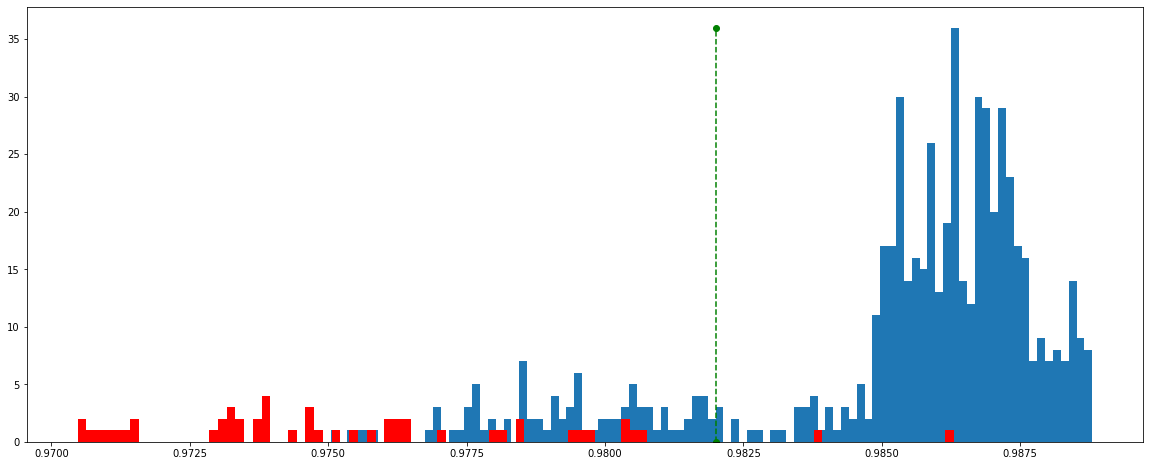

In [52]:
#@title Threshold: below which matching score do we consider a screenshot suspicious?  { run: "auto", display-mode: "form" }

threshold = 0.982 #@param {type:"slider", min:0.95, max:1.0, step:0.0005}
test_mask = test_scores < threshold
train_mask = train_scores >= threshold
n, _, _ = plt.hist(train_scores, bins=100);
plt.hist(test_scores, bins=100, color='red')
plt.plot((threshold, threshold), (0, n.max()),  color='green', marker='o', linestyle='dashed');
print("Suspicious Screenshots: {:d} von {:d}".format(np.count_nonzero(test_mask), test_mask.shape[0]));
print("Unsuspicious Screenshots: {:d} von {:d}".format(np.count_nonzero(train_mask), train_mask.shape[0]));

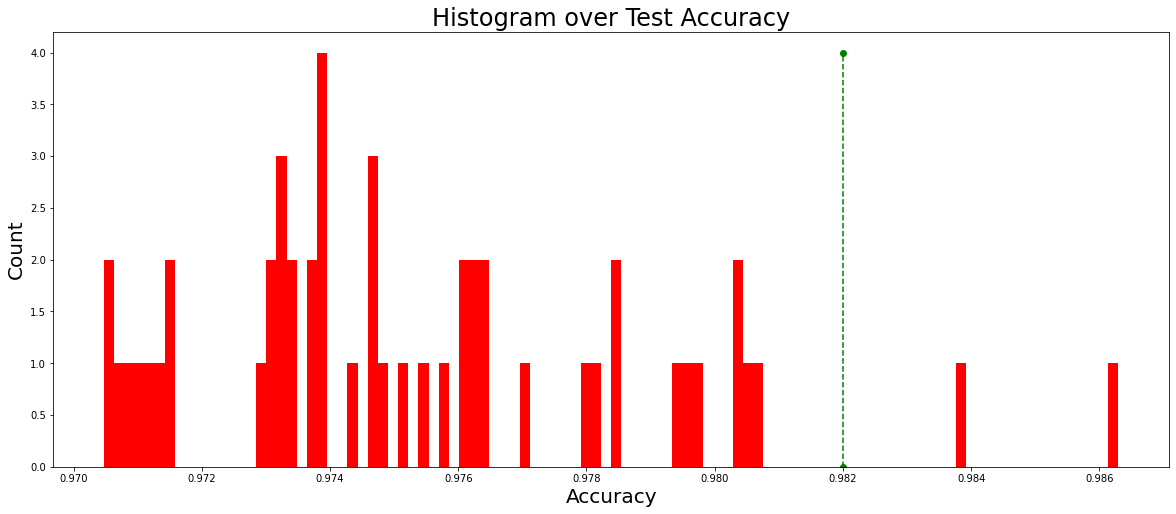

In [53]:
plt.title('Histogram over Test Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

n, _, _ = plt.hist(test_scores, bins=100, color='red')
plt.plot((threshold, threshold), (0, n.max()),  color='green', marker='o', linestyle='dashed');

## Predicted as correct

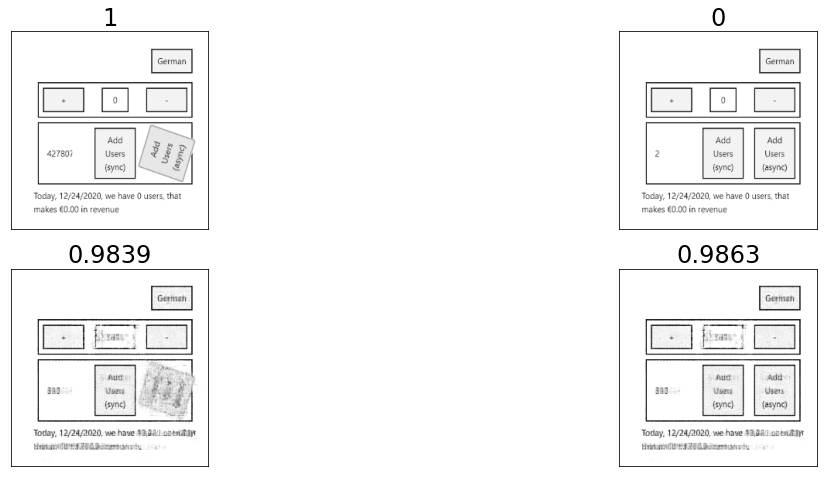

In [54]:
compare_samples(test[~test_mask], test_pred[~test_mask])

## Predicted as broken

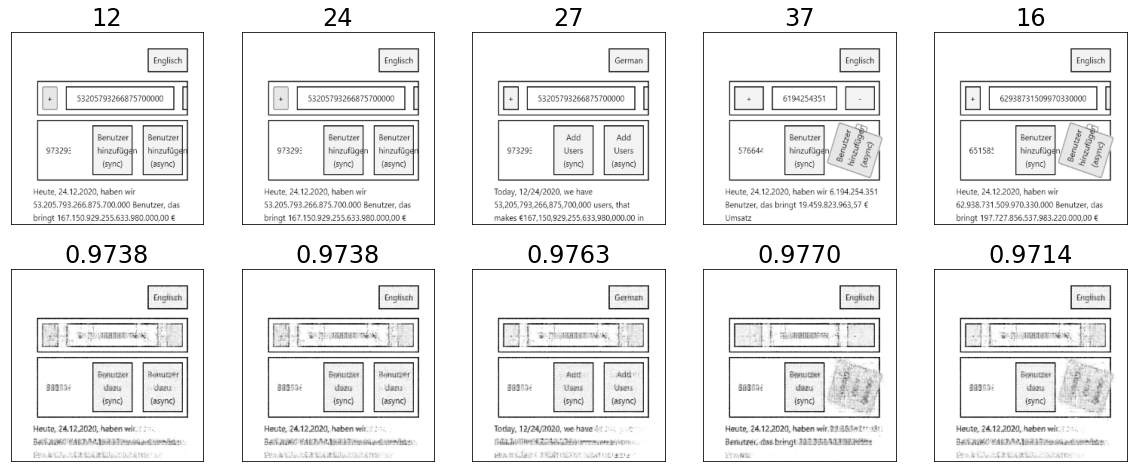

In [55]:
compare_samples(test[test_mask], test_pred[test_mask])

# Optional Step 5: Checking the numbers of zeros and overall average to check effect of L1 and L2 regularization

In [56]:
test_embedded_imgs = conv_encoder.predict(test)
test_embedded_imgs.shape

(51, 32)

In [57]:
test_embedded_imgs[0]

array([ -19.364073 ,  -22.814484 ,   84.206245 ,  -23.899927 ,
         44.171833 ,   64.71241  ,  -68.97723  ,  -21.014366 ,
         77.1814   ,  -66.71257  , -169.37386  ,   41.13796  ,
          3.4636045,   27.984507 ,   27.33282  ,   25.811317 ,
        123.258286 ,   88.595764 ,    4.2818975,   96.41012  ,
         10.68243  ,   40.794796 ,   27.742222 ,   30.2321   ,
         -4.758884 ,  113.67554  ,   12.45408  ,   37.4848   ,
         21.445007 ,   55.64905  , -108.97943  ,   37.953823 ],
      dtype=float32)

In [58]:
test_embedded_imgs[25]

array([   6.2011127,  -67.23801  ,   74.556175 ,  -23.99505  ,
         32.18282  ,   46.286964 ,  -54.12304  ,  -10.743152 ,
        104.37355  ,  -73.09544  , -166.44751  ,    9.815069 ,
         -3.279366 ,   26.060392 ,   36.531887 ,   51.522503 ,
        124.81512  ,   89.531975 ,   55.563328 ,   63.467163 ,
         28.114105 ,   26.516245 ,    3.1777017,   44.819782 ,
          4.2494397,  111.399445 ,    9.975675 ,   56.22581  ,
          0.6123485,   67.73442  , -115.74887  ,   18.927979 ],
      dtype=float32)

In [59]:
test_embedded_imgs[50]

array([   0.2195578,  -62.830082 ,   55.71672  ,  -33.757042 ,
         32.92662  ,   27.324076 ,  -46.04503  ,  -17.00089  ,
        107.96119  ,  -81.97109  , -180.06549  ,   11.225154 ,
         10.056689 ,   17.627787 ,   34.841724 ,   51.701996 ,
        136.18613  ,   97.69343  ,   52.103825 ,   74.5967   ,
         32.616016 ,   29.758171 ,    9.30071  ,   36.19871  ,
         20.51082  ,  121.88271  ,   20.17669  ,   57.417072 ,
         -3.5010033,   60.72452  , -116.332924 ,   -4.2364993],
      dtype=float32)

In [60]:
test_embedded_imgs[7]

array([ -16.69608 ,   62.15687 ,   56.47493 ,  -51.635086,   71.51417 ,
         40.989468,  -30.292744,  -39.216248,   79.94349 ,  -60.19826 ,
       -145.70053 ,   47.580997,   57.17737 ,   22.616552,   23.168987,
         11.922397,  125.95752 ,   86.38638 ,  -14.505458,   20.6703  ,
         18.42112 ,   50.260014,   27.647125,   22.104513,   -8.446615,
        122.29669 ,   17.406939,   67.99734 ,   -8.82283 ,   82.60952 ,
        -85.19759 ,    9.625584], dtype=float32)

In [61]:
test_embedded_imgs[43]

array([ -15.723449 ,  -24.779043 ,   82.21342  ,  -25.317368 ,
         45.786167 ,   63.075104 ,  -67.42028  ,  -20.580917 ,
         79.381065 ,  -67.7942   , -167.83762  ,   40.041412 ,
          3.6390862,   28.33465  ,   26.783718 ,   24.404484 ,
        123.98137  ,   88.258865 ,    4.5500145,   97.52558  ,
         10.815412 ,   39.891205 ,   25.728012 ,   29.284643 ,
         -6.6782866,  113.285355 ,   11.710643 ,   39.977406 ,
         16.931599 ,   57.975216 , -109.12696  ,   35.61632  ],
      dtype=float32)

In [62]:
tf.reduce_mean(test_embedded_imgs).numpy(), tf.reduce_mean(encoding_dim - tf.math.count_nonzero(test_embedded_imgs, axis=1)).numpy()

(18.768505, 0)

# Optional Step 6: Looking at our embeddings

need to reduce to 2 dim to make them plotable

In [63]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/parameters.html
# https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
# https://pair-code.github.io/understanding-umap/
# https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668

!pip install umap-learn -q

     |████████████████████████████████| 88 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 61.2 MB/s 


In [64]:
import umap

In [65]:
%%time

if encoding_dim == 2:
  test_embedded_imgs = test_embedded_imgs
else:
  print('reducing dim using umap')
  # default
  reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
  # local structure (n_neighbors), a bit more stretched out (min_dist)
  # reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=.99)
  test_embedded_imgs = reducer.fit_transform(test_embedded_imgs)

reducing dim using umap
CPU times: user 6.45 s, sys: 34.7 ms, total: 6.49 s
Wall time: 6.77 s


In [66]:
test_embedded_imgs.shape

(51, 2)

In [67]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test_embedded_imgs = scaler.fit_transform(test_embedded_imgs)
test_embedded_imgs.shape

(51, 2)

In [68]:
# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

from PIL import Image

def plot_embeddings(embeddings_2d, images, min_dist = 0.2, zoom=0.1, plot_samples=True):
  plt.figure(figsize=(50, 50))
  cmap = plt.cm.tab10
  if plot_samples:
    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(embeddings_2d):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > min_dist: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            image = Image.fromarray(images[index])
            # image.putalpha(16)
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(image, cmap="gray", zoom=zoom ),
                position, 
                # bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2}
                )
            plt.gca().add_artist(imagebox)
  # plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100)
  plt.axis("off");

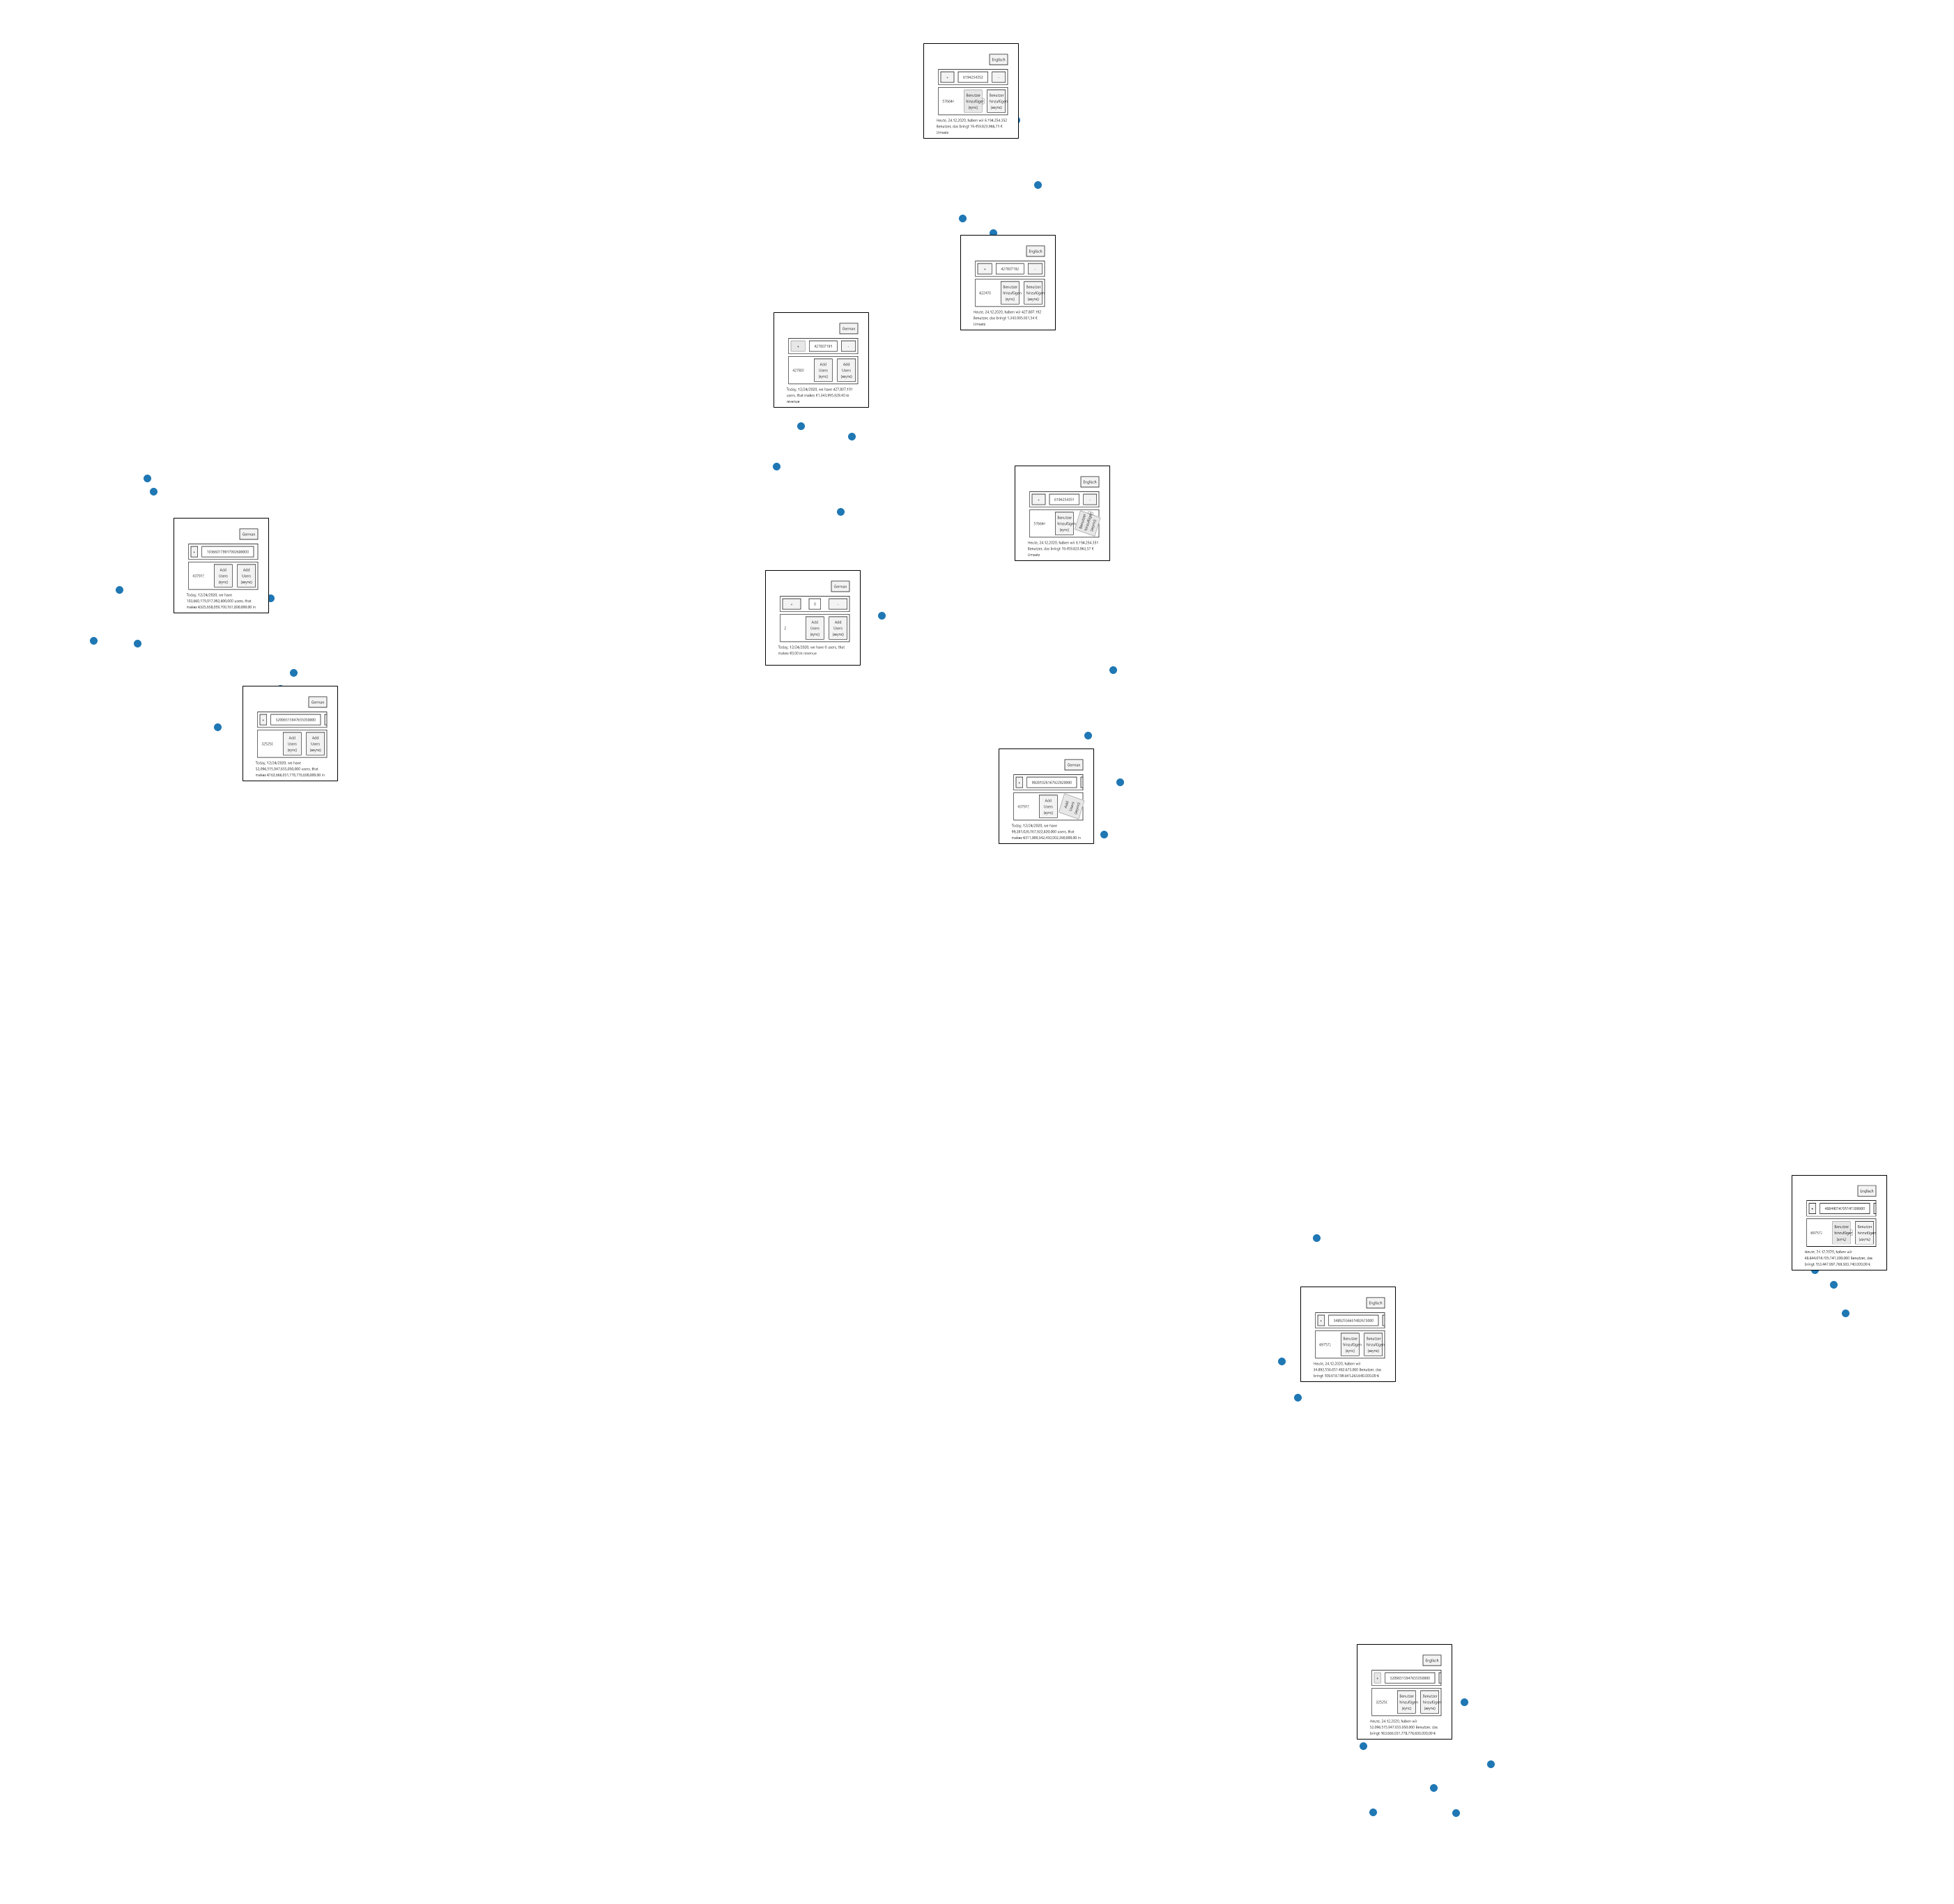

In [69]:
# how far need to labels be from each other in order not to clutter everthing
# might need a bit of adjustment 
min_dist = 0.1

# plot_embeddings(test_embedded_imgs, test, min_dist=min_dist, zoom=0.5, plot_samples=False)
plot_embeddings(test_embedded_imgs, test, min_dist=min_dist, zoom=0.5)

## Same for training data

reducing dim using umap


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


CPU times: user 3.89 s, sys: 100 ms, total: 3.99 s
Wall time: 5.77 s


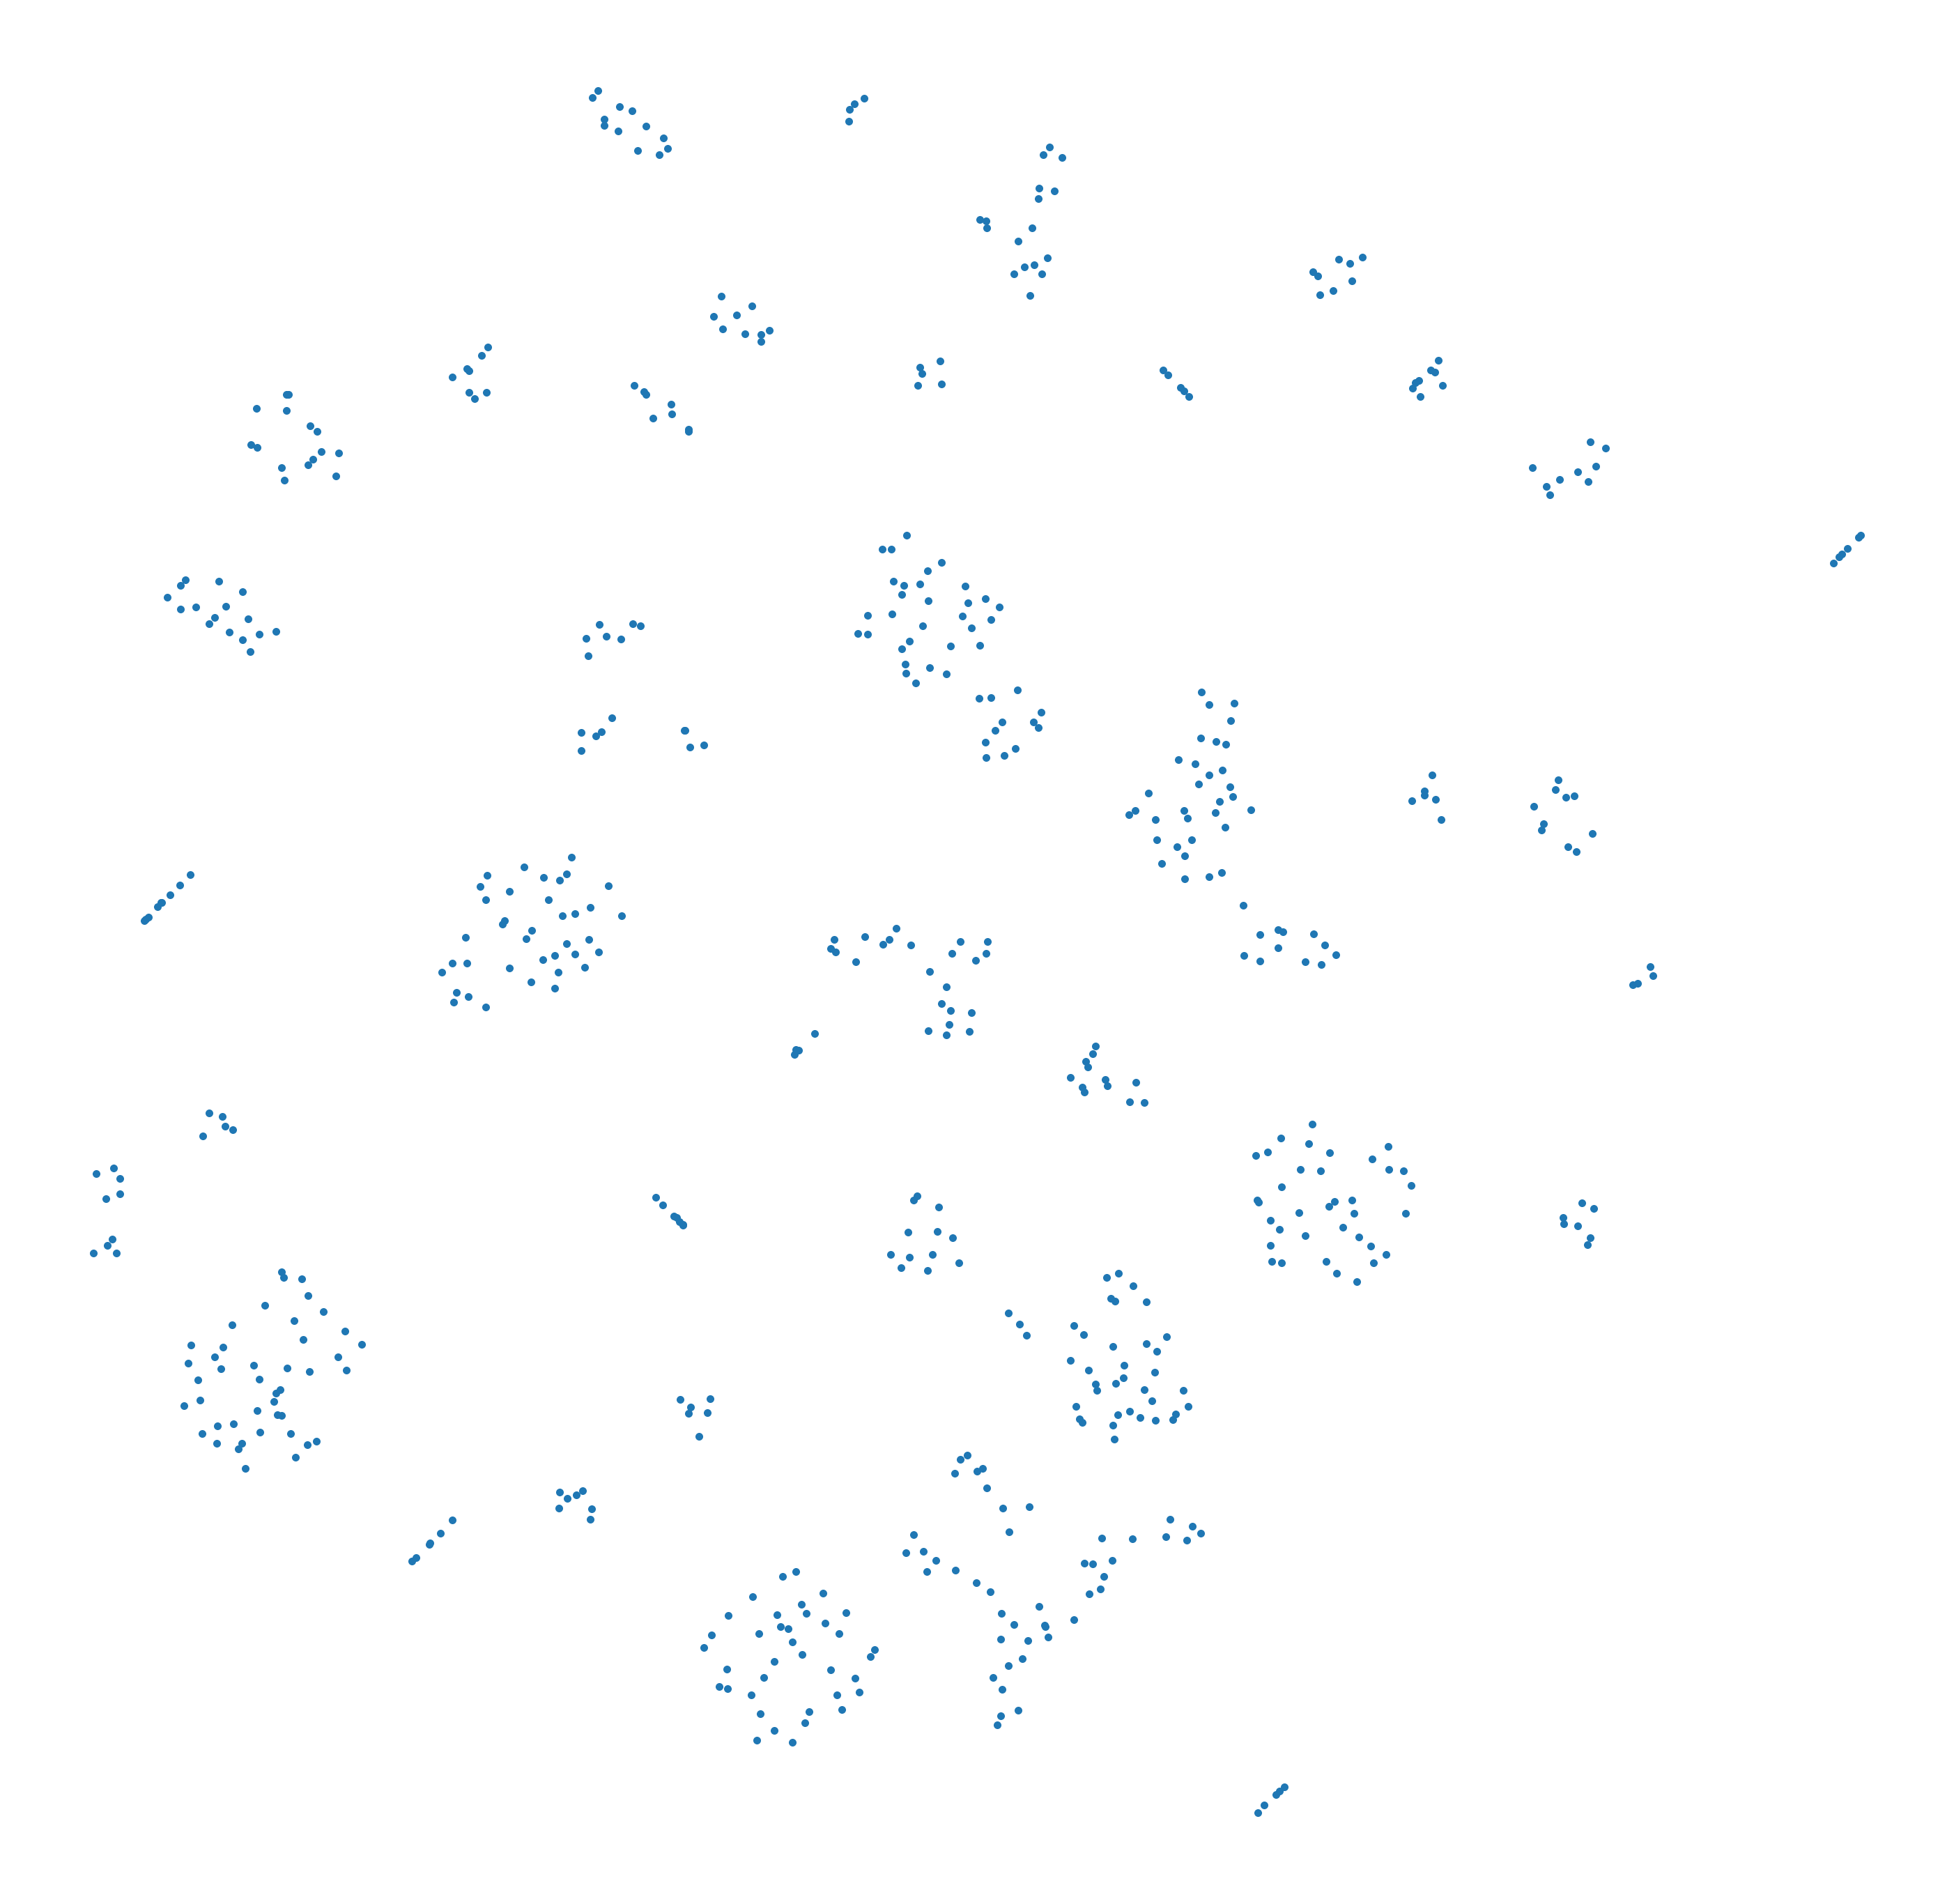

In [70]:
%%time

train_embedded_imgs = conv_encoder.predict(train)

if encoding_dim == 2:
  train_embedded_imgs = train_embedded_imgs
else:
  print('reducing dim using umap')
  # default
  # reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
  # local structure (n_neighbors), a bit more stretched out (min_dist)
  reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=.99)
  train_embedded_imgs = reducer.fit_transform(train_embedded_imgs)

train_embedded_imgs = scaler.fit_transform(train_embedded_imgs)

min_dist = 0.1

plot_embeddings(train_embedded_imgs, train, min_dist=min_dist, zoom=0.5, plot_samples=False)

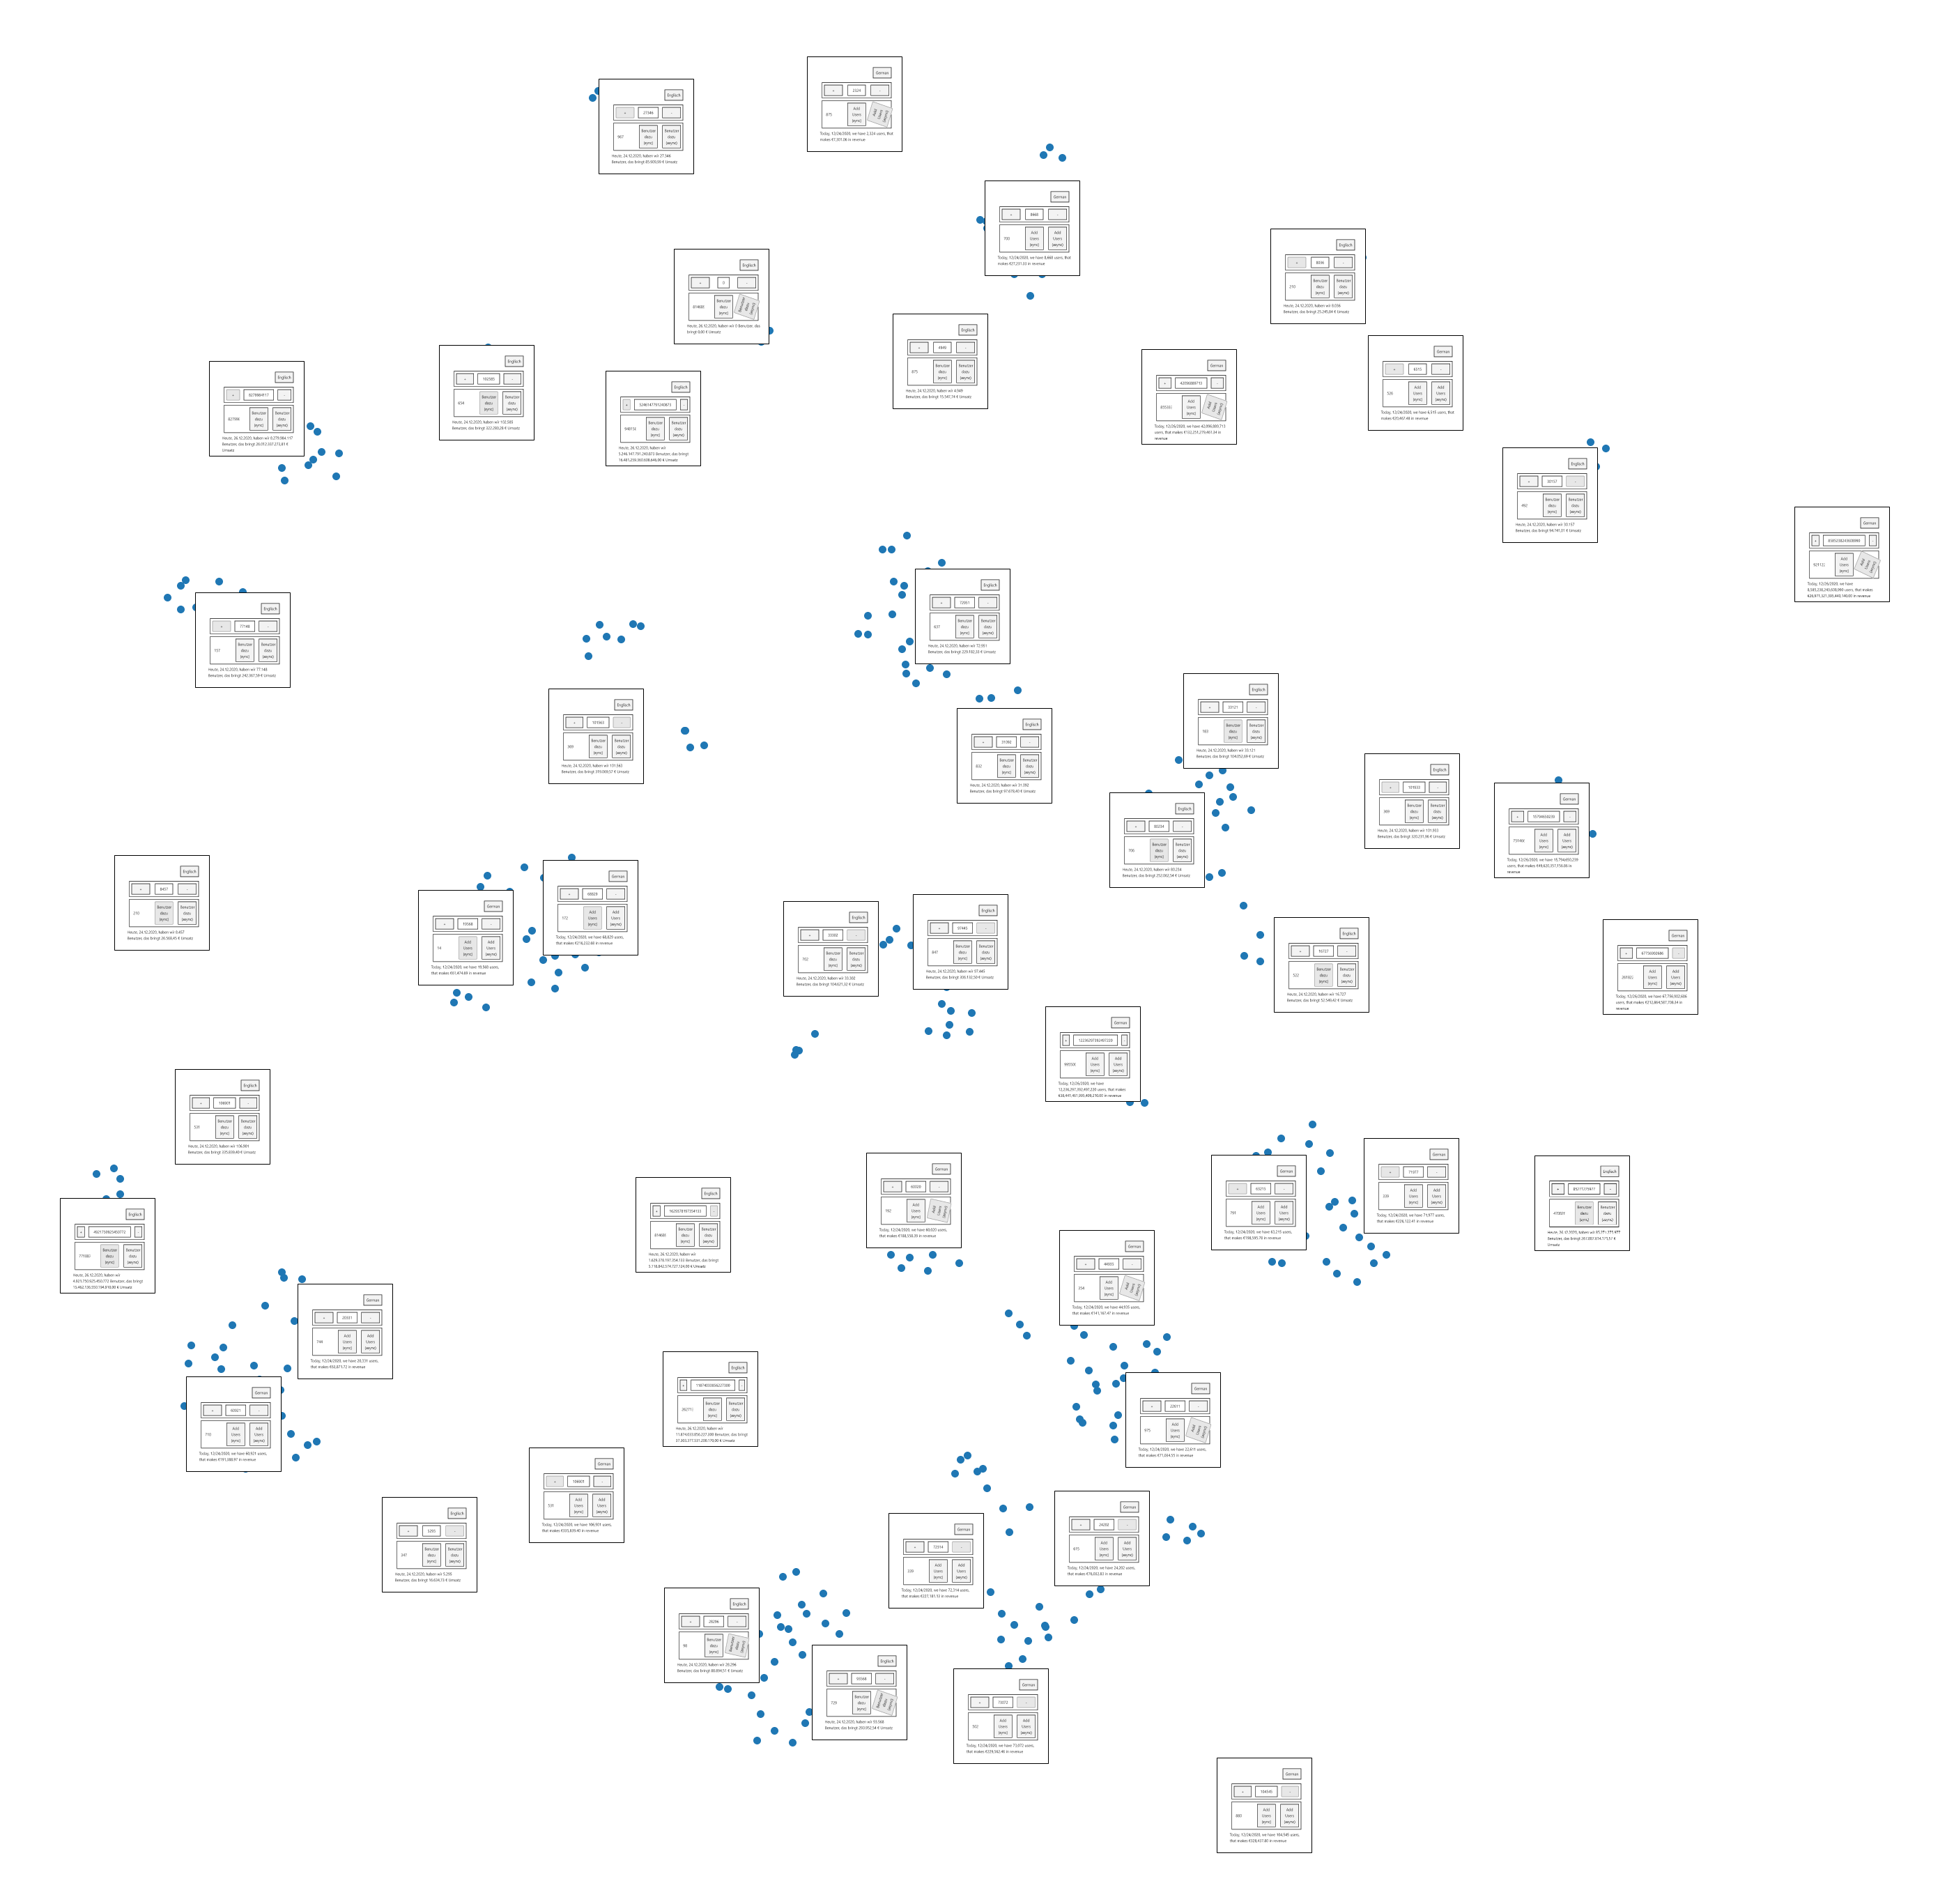

In [71]:
plot_embeddings(train_embedded_imgs, train, min_dist=min_dist, zoom=0.5, plot_samples=True)

# Optional Step 7: Clustering and looking into clusters

## HDBSCAN

* no parameters at all
* like DBSCAN
* but finds out epsilon by itself

https://github.com/scikit-learn-contrib/hdbscan

https://umap-learn.readthedocs.io/en/latest/faq.html#can-i-cluster-the-results-of-umap



In [72]:
!pip install -q hdbscan

     |████████████████████████████████| 5.2 MB 23.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [73]:
import hdbscan

In [74]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

def plot_dataset(X, y_pred=[0], fname=None, highlights=None):
    # last color is black to properly display label -1 as noise (black)
    colors = np.append(np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1)))), ['#000000'])
    plt.figure(figsize=(10, 10))

    if highlights is None:
          plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    else:
      plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred], alpha=0.2)
      plt.scatter(highlights[:, 0], highlights[:, 1], s=20, 
                  edgecolors='k',
                  color='w')

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    if fname:
        plt.savefig(fname)


In [75]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(train_embedded_imgs)
train_embedded_imgs.shape, cluster_labels.shape

((603, 2), (603,))

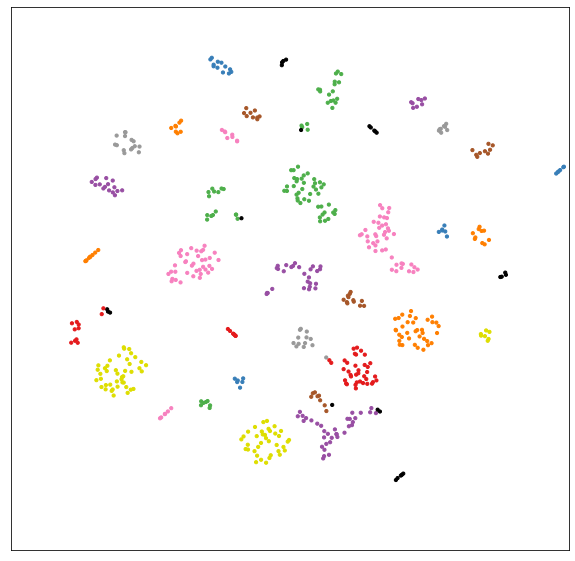

In [76]:
plot_dataset(train_embedded_imgs, cluster_labels)

In [77]:
labels, indices, inverse, counts = np.unique(cluster_labels, return_counts=True, return_index=True, return_inverse=True)
labels.shape, indices.shape, inverse.shape, counts.shape

((34,), (34,), (603,), (34,))

In [78]:
# which clusters contain the most samples (outliers is 0)
cluster_nr_ranking = np.argsort(counts)[::-1]
cluster_nr_ranking

array([31, 30, 27,  4, 18, 17, 11, 33, 15,  0, 21, 24, 25,  3, 16, 19, 14,
       26, 29,  5,  2, 23, 22,  7,  6, 32, 20,  9,  8, 12, 10, 13,  1, 28])

In [79]:
# cluster_nr = cluster_nr_ranking[1]
cluster_nr = cluster_nr_ranking[3]
cluster_points = np.where(inverse == cluster_nr)[0]
highlights = train_embedded_imgs[cluster_points]
higlight_images = train[cluster_points]
cluster_nr, highlights.shape

(4, (38, 2))

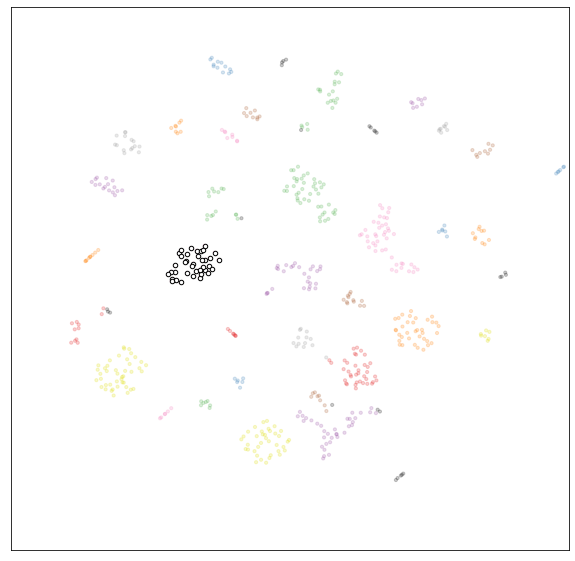

In [80]:
plot_dataset(train_embedded_imgs, cluster_labels, highlights=highlights)

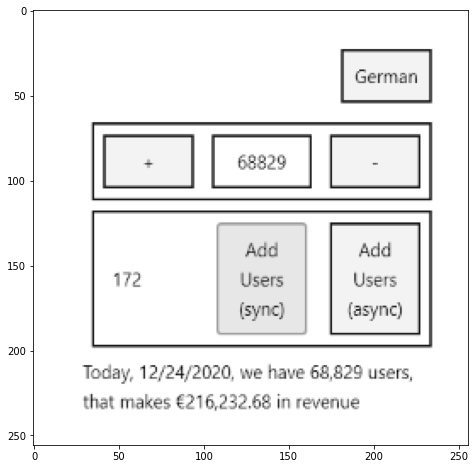

In [81]:
plt.imshow(higlight_images[0], cmap='gray');

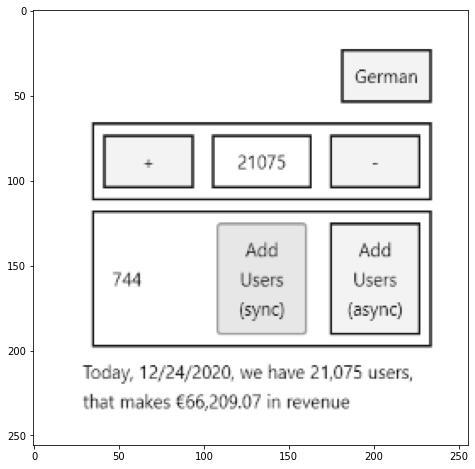

In [82]:
plt.imshow(higlight_images[10], cmap='gray');